In [ ]:
!pip install networkx matplotlib

In [1]:
from string import ascii_lowercase
from collections import OrderedDict
import networkx as nx
from matplotlib import pyplot as plt

ascii_lowercase_rev = "".join(reversed(ascii_lowercase))

def lexicographic_keyer(c):
    return ascii_lowercase.index(c)

def reverse_lexicographic_keyer(c):
    return ascii_lowercase_rev.index(c)
    
# Implement our own graph data structure so that we can run custom DFS on it
class Graph:
    def __init__(self, edges, edge_keyer=None, vertex_keyer=None):
        self.edge_keyer = edge_keyer
        self.vertex_keyer = vertex_keyer
        self.build_graph(edges)
        self._edges = edges
        
    def add_vertex_if_missing(self, v):
        if self.graph.get(v) is None:
            self.graph[v] = []
            
    def add_edge(self, e):
        start_vert, end_vert = e
        self.add_vertex_if_missing(start_vert)
        self.add_vertex_if_missing(end_vert)
        self.graph[start_vert].append(end_vert)
        
    def build_graph(self, edges):
        self.graph = OrderedDict()
        for e in edges:
            self.add_edge(e)
        if self.edge_keyer is not None:
            for edge_list in self.graph.values():
                edge_list.sort(key=self.edge_keyer)
        if self.vertex_keyer is not None:
            vertex_list = sorted(self.graph.keys(), key=self.vertex_keyer)
            for v in vertex_list:
                self.graph.move_to_end(v, last=True)
    
    def dfs(self, verbose=True):
        clock = 0
        begin = {}
        finish = {}
        dfs_forest = nx.DiGraph()
        
        def is_explored(v):
            if verbose:
                print(f"is_explored({v}): {begin.get(v) is not None }")
            return begin.get(v) is not None
            
        def dfs_alg(v):
            nonlocal clock
            if verbose:
                print(f"running dfs_alg on {v}")
            begin[v] = clock
            clock += 1
            dfs_forest.add_node(v)
            for u in self.graph.get(v):
                if not is_explored(u):
                    dfs_forest.add_edge(v, u)
                    dfs_alg(u)
            finish[v] = clock
            clock += 1
            
        for v in self.graph.keys():
            if not is_explored(v):
                dfs_alg(v)
        
        return (begin, finish, clock, dfs_forest)

    def to_nx(self):
        g = nx.DiGraph()
        g.add_edges_from(self._edges)
        return g

In [2]:
EDGES = [
    ('u', 'v'),
    ('u', 'x'),
    ('u', 'y'),
    ('v', 'y'),
    ('x', 'v'),
    ('y', 'u'),
    ('y', 'z'),
]
G_a = Graph(EDGES, edge_keyer=lexicographic_keyer, vertex_keyer=lexicographic_keyer)
G_b = Graph(EDGES, edge_keyer=reverse_lexicographic_keyer, vertex_keyer=reverse_lexicographic_keyer)
G_c = Graph(EDGES, edge_keyer=reverse_lexicographic_keyer, vertex_keyer=lexicographic_keyer)


In [3]:
from pprint import pprint
def run_dfs(g):
    pprint(g.graph)
    res = g.dfs(verbose=False)
    pprint(res)
    return res
results = [run_dfs(g) +(g.to_nx(),) for g in [G_a, G_b, G_c]]
results

OrderedDict([('u', ['v', 'x', 'y']),
             ('v', ['y']),
             ('x', ['v']),
             ('y', ['u', 'z']),
             ('z', [])])
({'u': 0, 'v': 1, 'x': 7, 'y': 2, 'z': 3},
 {'u': 9, 'v': 6, 'x': 8, 'y': 5, 'z': 4},
 10,
 <networkx.classes.digraph.DiGraph object at 0x1132d99d0>)
OrderedDict([('z', []),
             ('y', ['z', 'u']),
             ('x', ['v']),
             ('v', ['y']),
             ('u', ['y', 'x', 'v'])])
({'u': 3, 'v': 5, 'x': 4, 'y': 2, 'z': 0},
 {'u': 8, 'v': 6, 'x': 7, 'y': 9, 'z': 1},
 10,
 <networkx.classes.digraph.DiGraph object at 0x10e91fc50>)
OrderedDict([('u', ['y', 'x', 'v']),
             ('v', ['y']),
             ('x', ['v']),
             ('y', ['z', 'u']),
             ('z', [])])
({'u': 0, 'v': 6, 'x': 5, 'y': 1, 'z': 2},
 {'u': 9, 'v': 7, 'x': 8, 'y': 4, 'z': 3},
 10,
 <networkx.classes.digraph.DiGraph object at 0x10e932610>)


[({'u': 0, 'v': 1, 'y': 2, 'z': 3, 'x': 7},
  {'z': 4, 'y': 5, 'v': 6, 'x': 8, 'u': 9},
  10,
  <networkx.classes.digraph.DiGraph at 0x11343cd10>),
 ({'z': 0, 'y': 2, 'u': 3, 'x': 4, 'v': 5},
  {'z': 1, 'v': 6, 'x': 7, 'u': 8, 'y': 9},
  10,
  <networkx.classes.digraph.DiGraph at 0x10e917150>),
 ({'u': 0, 'y': 1, 'z': 2, 'x': 5, 'v': 6},
  {'z': 3, 'y': 4, 'v': 7, 'x': 8, 'u': 9},
  10,
  <networkx.classes.digraph.DiGraph at 0x10e930a90>)]

In [4]:
# https://stackoverflow.com/a/71346836
def topo_pos(G):
    """Display in topological order, with simple offsetting for legibility"""
    pos_dict = {}
    for i, node_list in enumerate(nx.topological_generations(G)):
        x_offset = len(node_list) / 2
        y_offset = 0.1
        for j, name in enumerate(node_list):
            pos_dict[name] = (j - x_offset, -i + j * y_offset)

    return pos_dict

def format_begin_finish(vtx, begin, finish):
    return f"{vtx}\nB:{begin[vtx]}/F:{finish[vtx]}"

def classify_edge(edge, begin, finish, dfs_forest):
    u, v = edge
    bu = begin[u]
    bv = begin[v]
    fu = finish[u]
    fv = finish[v]
    if bv < fv < bu < fu:
        return f'({u},{v}) CROSS'
    elif bv < bu < fu < fv:
        return f'({u},{v}) BACK'
    elif bu < bv < fv < fu:
        is_tree = edge in nx.edges(dfs_forest)
        # print(f"edge {edge} is tree {is_tree}")
        if is_tree:
            return f'({u},{v}) TREE'
        else:
            return f'({u},{v}) FORWARD'
    else:
        raise Exception('WTF is going on?')
    
def draw_dfs_forest(result, title):
    begin, finish, _, dfs_forest, _g = result
    labels = {}
    for vtx in begin.keys():
        labels[vtx] = format_begin_finish(vtx, begin, finish)
    plt.figure(figsize=(8, 8))
    nx.draw_networkx(dfs_forest, pos=topo_pos(dfs_forest), labels=labels,
                     with_labels=True, node_color='lightblue', font_weight='bold',
                     node_size=2300, font_size=12, arrows=True)
    plt.title(title)
    plt.show()

def draw_annotated_graph(result, title):
    begin, finish, _, dfs_forest, graph = result
    labels = {}
    for vtx in begin.keys():
        labels[vtx] = format_begin_finish(vtx, begin, finish)
    edge_labels={edge: classify_edge(edge, begin, finish, dfs_forest) for edge in nx.edges(graph)}
                 
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(graph, pos=nx.planar_layout(graph), node_color='lightblue', node_size=2300)
    nx.draw_networkx_labels(graph, pos=nx.planar_layout(graph),labels=labels, font_weight='bold', font_size=12)
    nx.draw_networkx_edges(graph, pos=nx.planar_layout(graph),  arrowstyle='-|>', node_size=2300)
    nx.draw_networkx_edge_labels(graph, pos=nx.planar_layout(graph), edge_labels=edge_labels, label_pos=0.4, font_size=8)
    plt.title(title)
    plt.show()

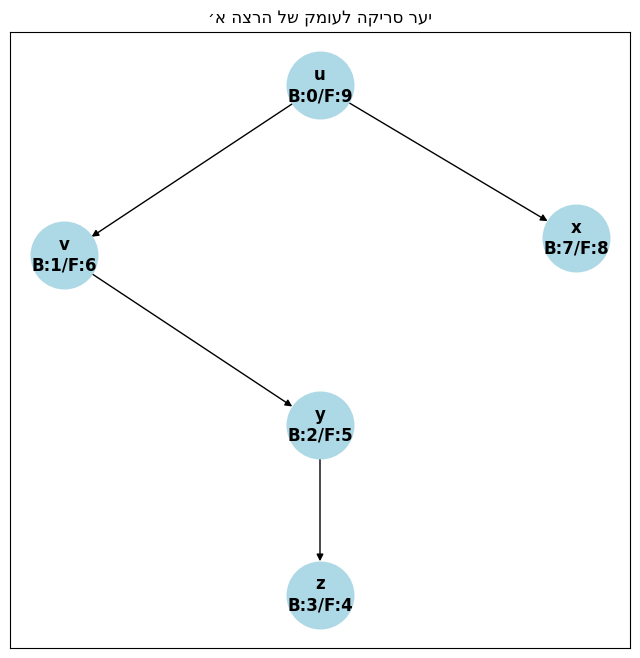

In [5]:
draw_dfs_forest(results[0], "יער סריקה לעומק של הרצה א׳"[::-1])

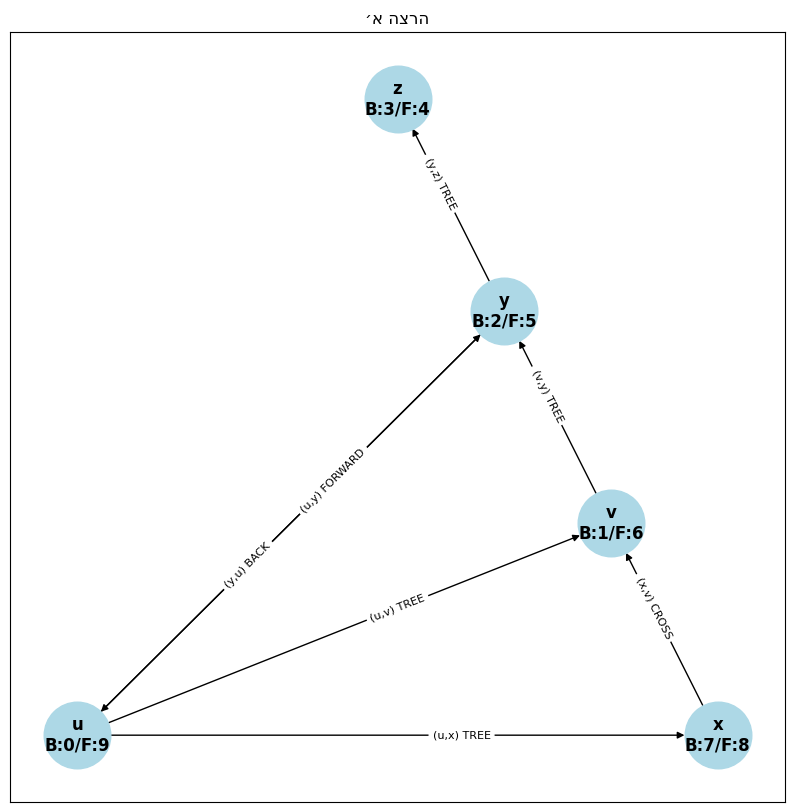

In [6]:
draw_annotated_graph(results[0], 'הרצה א׳'[::-1])

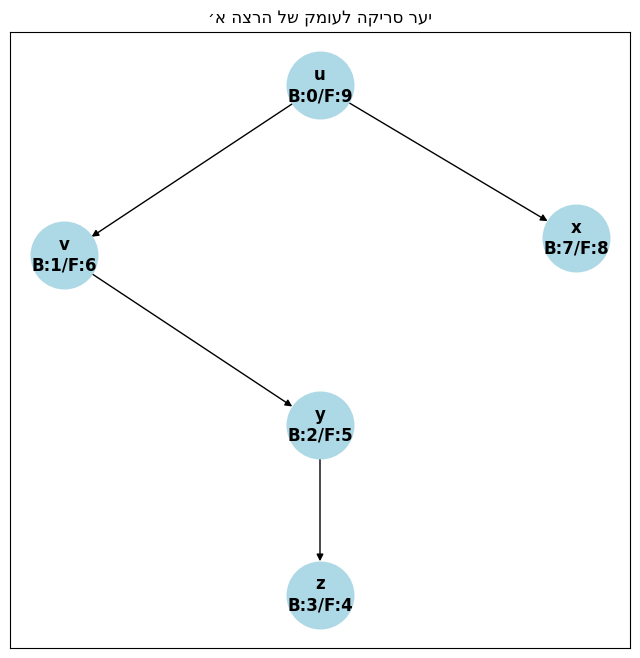

In [7]:
draw_dfs_forest(results[0], "יער סריקה לעומק של הרצה א׳"[::-1])

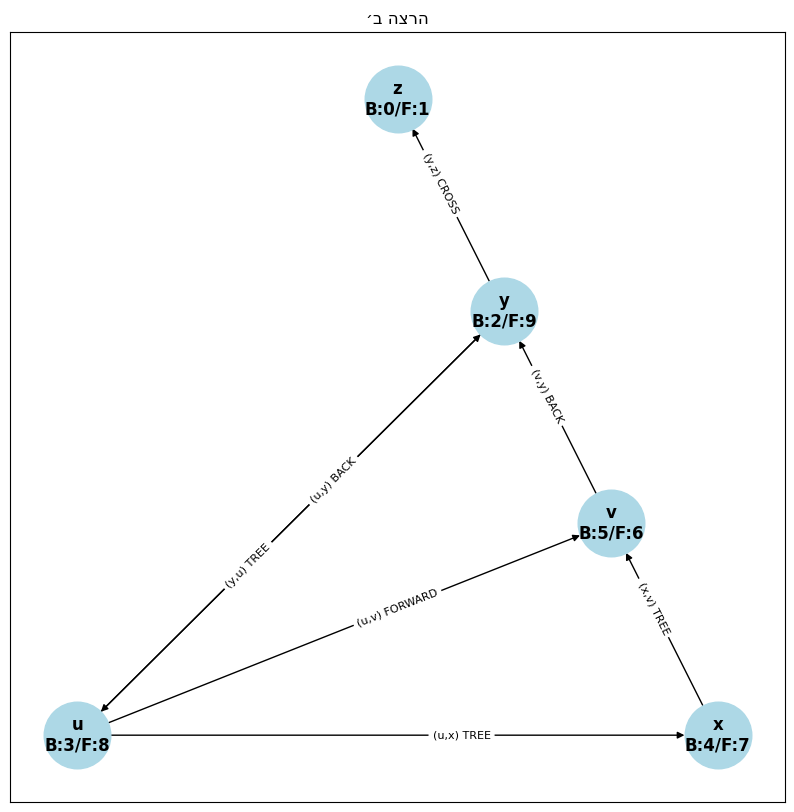

In [8]:
draw_annotated_graph(results[1], 'הרצה ב׳'[::-1])

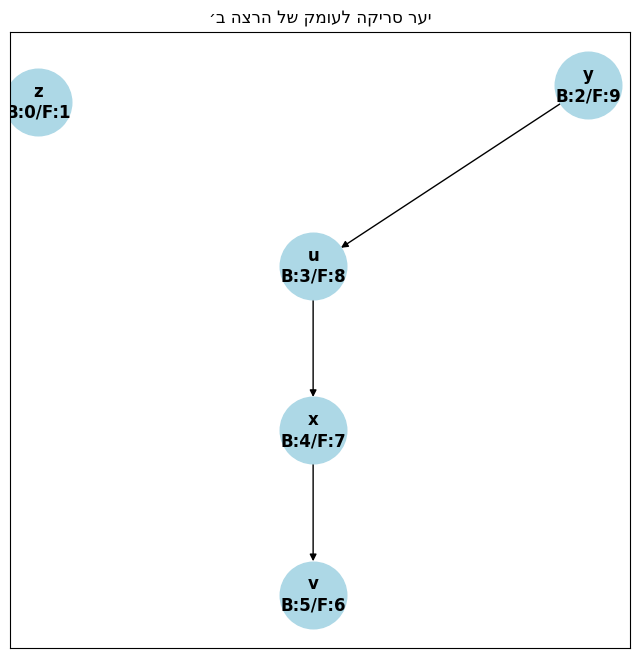

In [9]:
draw_dfs_forest(results[1], "יער סריקה לעומק של הרצה ב׳"[::-1])

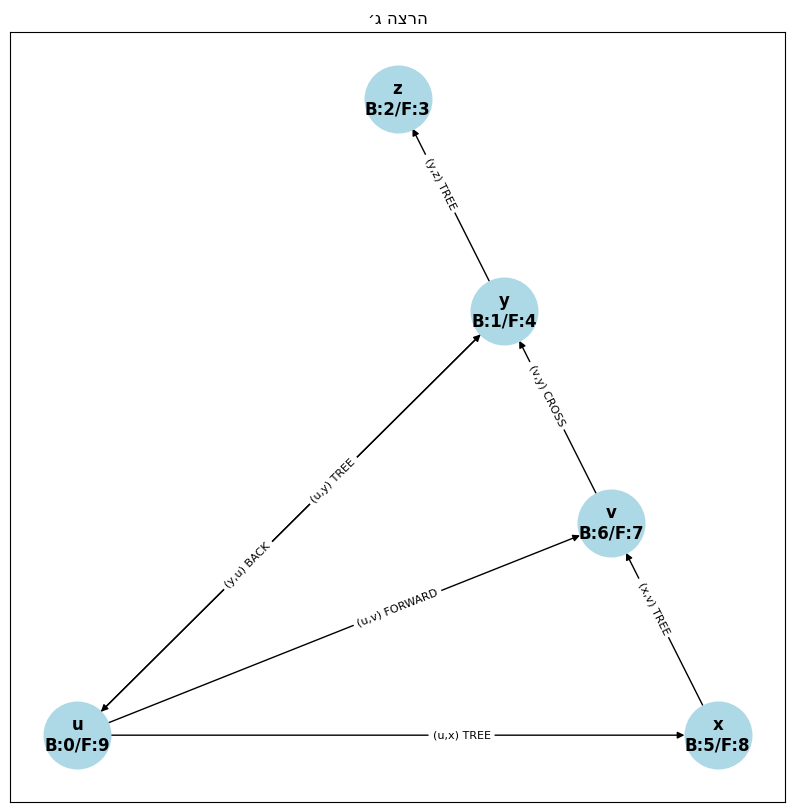

In [10]:
draw_annotated_graph(results[2], 'הרצה ג׳'[::-1])

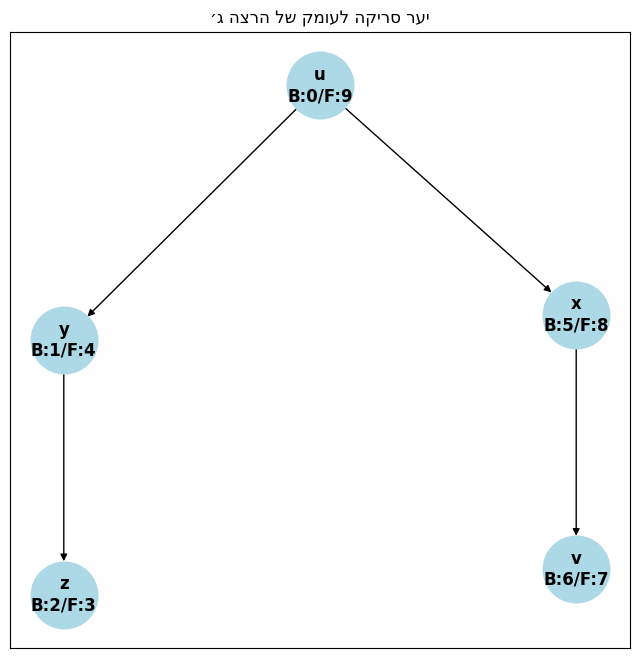

In [11]:
draw_dfs_forest(results[2], "יער סריקה לעומק של הרצה ג׳"[::-1])